In [422]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = ''

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #pythonhashseed 환경변수 설정
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')


In [423]:
path = "C:/Users/yis82/OneDrive/Desktop/daegu-traffic-accident-prediction/data"
fpath = "C:/Users/yis82/OneDrive/Desktop/daegu-traffic-accident-prediction/data/external_open"

In [424]:
train_data = pd.read_csv(path + "/train.csv")
test_data = pd.read_csv(path + "/test.csv")
# acc = pd.read_csv(fpath + "/countrywide_accident.csv")
CCTV = pd.read_csv(fpath + "/대구 CCTV 정보.csv", encoding = 'cp949')
light = pd.read_csv(fpath + "/대구 보안등 정보.csv", encoding = 'cp949', low_memory=False)
child_protect = pd.read_csv(fpath + "/대구 어린이 보호 구역 정보.csv", encoding = 'cp949')
parking = pd.read_csv(fpath + "/대구 주차장 정보.csv", encoding = 'cp949')

In [425]:
def process_location_data(df, address_column, drop_columns):
  location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
  df[['도시', '구', '동', '우편번호']] = df[address_column].str.extract(location_pattern)
  df = df.drop(drop_columns, axis = 1)
  return df

In [426]:
train = train_data.copy()
test = test_data.copy()

In [427]:
CCTV = process_location_data(CCTV, '소재지지번주소', ['소재지지번주소', '우편번호'])
light = process_location_data(light, '소재지지번주소', ['소재지지번주소', '우편번호'])
parking = process_location_data(parking, '소재지지번주소', ['소재지지번주소', '우편번호'])
child_protect = process_location_data(child_protect, '소재지지번주소', ['소재지지번주소', '우편번호'])

CCTV_notnull = CCTV.dropna(subset=['동'])
light_notnull = light.dropna(subset=['동'])
parking_notnull = parking.dropna(subset=['동'])
child_protect_notnull = child_protect.dropna(subset=['동'])

In [428]:
light_df = light_notnull.groupby('동').size().reset_index(name='보안등개수')
light_df

,동,보안등개수
0,가창면,1123
1,각산동,137
2,갈산동,349
3,감삼동,932
4,검단동,391
...,...,...
221,화원읍,940
222,화전동,22
223,황금1동,153
224,황금2동,590


In [429]:
CCTV_num = CCTV_notnull.groupby('동').size().reset_index(name='CCTV개수')
CCTV_num

,동,CCTV개수
0,가창면,17
1,가천동,1
2,각산동,2
3,갈산동,1
4,감삼동,12
...,...,...
167,호산동,10
168,화원읍,39
169,황금동,9
170,효령면,9


In [430]:
CCTV_pre = CCTV_notnull[['동', '단속구분']].groupby(['동', '단속구분']).size().unstack()
CCTV_cat = CCTV_pre.add_prefix('단속구분_')
CCTV_cat = CCTV_cat.fillna(0)
CCTV_cat

단속구분,단속구분_1,단속구분_2,단속구분_4,단속구분_99
동,,,,
가창면,6.0,11.0,0.0,0.0
가천동,0.0,1.0,0.0,0.0
각산동,1.0,1.0,0.0,0.0
갈산동,1.0,0.0,0.0,0.0
감삼동,1.0,3.0,8.0,0.0
...,...,...,...,...
호산동,0.0,6.0,4.0,0.0
화원읍,12.0,23.0,0.0,4.0
황금동,3.0,6.0,0.0,0.0


In [431]:
CCTV_df = pd.merge(CCTV_num, CCTV_cat, how = 'left', on = '동')

In [432]:
CCTV_df

,동,CCTV개수,단속구분_1,단속구분_2,단속구분_4,단속구분_99
0,가창면,17,6.0,11.0,0.0,0.0
1,가천동,1,0.0,1.0,0.0,0.0
2,각산동,2,1.0,1.0,0.0,0.0
3,갈산동,1,1.0,0.0,0.0,0.0
4,감삼동,12,1.0,3.0,8.0,0.0
...,...,...,...,...,...,...
167,호산동,10,0.0,6.0,4.0,0.0
168,화원읍,39,12.0,23.0,0.0,4.0
169,황금동,9,3.0,6.0,0.0,0.0
170,효령면,9,7.0,1.0,0.0,1.0


In [433]:
parking_cat = pd.get_dummies(parking_notnull[['동', '급지구분']], columns=['급지구분'], prefix='급지')
parking_num = parking_notnull.groupby('동').size().reset_index(name='주차장개수')
parking_df = pd.merge(parking_num, parking_cat, how = 'left', on = '동')

In [434]:
parking_df

,동,주차장개수,급지_1,급지_2,급지_3
0,가창면,2,False,False,True
1,가창면,2,False,False,True
2,갈산동,4,False,False,True
3,갈산동,4,False,False,True
4,갈산동,4,False,False,True
...,...,...,...,...,...
768,화원읍,14,False,False,True
769,화전동,1,True,False,False
770,황금동,3,False,True,False
771,황금동,3,False,True,False


In [435]:
elementary_num = child_protect_notnull.groupby('동')['대상시설명'].nunique()
elementary_df = pd.DataFrame(elementary_num).reset_index()
elementary_df.rename(columns={'대상시설명':"초등학교개수"}, inplace=True)
elementary_df

,동,초등학교개수
0,가창면,4
1,검단동,1
2,고성동1가,1
3,고성동2가,1
4,관음동,5
...,...,...
66,하빈면,4
67,학정동,7
68,현풍면,11
69,화원읍,19


In [436]:
cols = ['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO']
train = train[cols]
train.isna().sum()


ID      0
사고일시    0
요일      0
기상상태    0
시군구     0
도로형태    0
노면상태    0
사고유형    0
ECLO    0
dtype: int64

In [437]:
train

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,3
...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,3
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,3
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,10
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,3


In [438]:
train["사고일시"] = train["사고일시"].astype("datetime64[ns]")
train["사고월"] = train["사고일시"].dt.month.astype(str)
train["사고일"] = train["사고일시"].dt.day.astype(str)
train["사고시간"] = train["사고일시"].dt.hour.astype(str)

train = train.drop("사고일시", axis=1)
location_pattern = r"(\S+) (\S+) (\S+)"
train[["도시", "구", "동"]] = train["시군구"].str.extract(location_pattern)
train = train.drop(columns=["시군구"])

In [439]:
# test도 train처럼 맞춰주기

test['사고일시'] = test['사고일시'].astype('datetime64[ns]')
test['사고월'] = test['사고일시'].dt.month.astype(str)
test['사고일'] = test['사고일시'].dt.day.astype(str)
test['사고시간'] = test['사고일시'].dt.hour.astype(str)

test = test.drop('사고일시', axis = 1)

location_pattern = r'(\S+) (\S+) (\S+)'
test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])

In [440]:
join_1 = pd.merge(train, CCTV_df, on = '동', how = 'left')
join_2 = pd.merge(join_1, light_df, on = '동', how = 'left')
join_3 = pd.merge(join_2, parking_df, on = '동', how = 'left')
join_3 = join_3.drop_duplicates("ID")
join_4 = pd.merge(join_3, elementary_df, on = '동', how = 'left')
train_raw = join_4.fillna(0).copy()
train_raw

,ID,요일,기상상태,도로형태,노면상태,사고유형,ECLO,사고월,사고일,사고시간,도시,구,동,CCTV개수,단속구분_1,단속구분_2,단속구분_4,단속구분_99,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
0,ACCIDENT_00000,화요일,맑음,단일로 - 기타,건조,차대사람,5,1,1,0,대구광역시,중구,대신동,5.0,0.0,1.0,4.0,0.0,391.0,11.0,True,False,False,2.0
1,ACCIDENT_00001,화요일,흐림,단일로 - 기타,건조,차대사람,3,1,1,0,대구광역시,달서구,감삼동,12.0,1.0,3.0,8.0,0.0,932.0,4.0,False,False,True,0.0
2,ACCIDENT_00002,화요일,맑음,단일로 - 기타,건조,차대사람,3,1,1,1,대구광역시,수성구,두산동,4.0,2.0,2.0,0.0,0.0,473.0,0.0,0,0,0,5.0
3,ACCIDENT_00003,화요일,맑음,단일로 - 기타,건조,차대차,5,1,1,2,대구광역시,북구,복현동,10.0,2.0,8.0,0.0,0.0,534.0,14.0,False,True,False,11.0
4,ACCIDENT_00004,화요일,맑음,단일로 - 기타,건조,차대차,3,1,1,4,대구광역시,동구,신암동,12.0,2.0,10.0,0.0,0.0,1995.0,1.0,False,True,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,교차로 - 교차로안,건조,차대차,3,12,31,19,대구광역시,수성구,수성동3가,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1.0
39605,ACCIDENT_39605,금요일,맑음,단일로 - 기타,건조,차대차,3,12,31,19,대구광역시,달서구,상인동,30.0,4.0,11.0,12.0,3.0,843.0,5.0,False,False,True,0.0
39606,ACCIDENT_39606,금요일,맑음,교차로 - 교차로안,건조,차대차,10,12,31,21,대구광역시,달서구,월성동,22.0,1.0,8.0,13.0,0.0,164.0,1.0,False,True,False,0.0
39607,ACCIDENT_39607,금요일,맑음,기타 - 기타,건조,차대차,3,12,31,22,대구광역시,달서구,장동,1.0,1.0,0.0,0.0,0.0,210.0,1.0,False,False,True,0.0


In [441]:
join_1 = pd.merge(test, CCTV_df, on = '동', how = 'left')
join_2 = pd.merge(join_1, light_df, on = '동', how = 'left')
join_3 = pd.merge(join_2, parking_df, on = '동', how = 'left')
join_3 = join_3.drop_duplicates("ID")
join_4 = pd.merge(join_3, elementary_df, on = '동', how = 'left')
test_raw = join_4.fillna(0).copy()
# len(test_raw['동'].unique())
test_raw

,ID,요일,기상상태,도로형태,노면상태,사고유형,사고월,사고일,사고시간,도시,구,동,CCTV개수,단속구분_1,단속구분_2,단속구분_4,단속구분_99,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
0,ACCIDENT_39609,토요일,맑음,교차로 - 교차로안,건조,차대사람,1,1,1,대구광역시,수성구,상동,4.0,0.0,4.0,0.0,0.0,700.0,0.0,0,0,0,5.0
1,ACCIDENT_39610,토요일,맑음,단일로 - 기타,건조,차대사람,1,1,1,대구광역시,수성구,지산동,7.0,0.0,7.0,0.0,0.0,0.0,2.0,False,False,True,10.0
2,ACCIDENT_39611,토요일,맑음,교차로 - 교차로안,건조,차대차,1,1,4,대구광역시,수성구,수성동2가,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1.0
3,ACCIDENT_39612,토요일,맑음,단일로 - 기타,건조,차대차,1,1,4,대구광역시,수성구,신매동,11.0,2.0,9.0,0.0,0.0,0.0,3.0,False,True,False,7.0
4,ACCIDENT_39613,토요일,맑음,교차로 - 교차로안,건조,차대차,1,1,6,대구광역시,달서구,감삼동,12.0,1.0,3.0,8.0,0.0,932.0,4.0,False,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,단일로 - 터널,건조,차대차,12,31,18,대구광역시,남구,대명동,62.0,7.0,20.0,35.0,0.0,5253.0,21.0,True,False,False,26.0
10959,ACCIDENT_50568,토요일,맑음,단일로 - 기타,건조,차대차,12,31,18,대구광역시,수성구,시지동,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0,0,0,5.0
10960,ACCIDENT_50569,토요일,맑음,단일로 - 기타,건조,차대차,12,31,20,대구광역시,수성구,연호동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
10961,ACCIDENT_50570,토요일,맑음,교차로 - 교차로부근,건조,차대차,12,31,20,대구광역시,수성구,범물동,7.0,2.0,5.0,0.0,0.0,0.0,0.0,0,0,0,7.0


In [442]:
invalid_dongs = train_raw[~train_raw['동'].isin(test_raw['동'])]
train_raw = train_raw[~train_raw['동'].isin(invalid_dongs['동'])]

In [443]:
print(len(train_raw['동'].unique()))
print(len(test_raw['동'].unique()))

190
190


In [444]:
train_cat = pd.get_dummies(data = train_raw, columns=['요일','기상상태','도로형태','노면상태', '사고유형', '구'])
train_cat = train_cat.drop(['도시'], axis = 1)

In [445]:
test_cat = pd.get_dummies(data = test_raw, columns=['요일','기상상태','도로형태','노면상태', '사고유형', '구'])
test_cat = test_cat.drop(['도시'], axis = 1)

In [446]:
train_col = list(train_cat.columns)
test_col = list(test_cat.columns)
list(set(train_col) - set(test_col))

['ECLO', '기상상태_안개']

In [447]:
foggy = [0] * len(test_cat)
test_cat['기상상태_안개'] = foggy
test_cat

,ID,사고월,사고일,사고시간,동,CCTV개수,단속구분_1,단속구분_2,단속구분_4,단속구분_99,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,기상상태_기타,기상상태_눈,기상상태_맑음,기상상태_비,기상상태_흐림,도로형태_교차로 - 교차로부근,도로형태_교차로 - 교차로안,도로형태_교차로 - 교차로횡단보도내,도로형태_기타 - 기타,도로형태_단일로 - 고가도로위,도로형태_단일로 - 교량,도로형태_단일로 - 기타,도로형태_단일로 - 지하차도(도로)내,도로형태_단일로 - 터널,도로형태_미분류 - 미분류,도로형태_주차장 - 주차장,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,기상상태_안개
0,ACCIDENT_39609,1,1,1,상동,4.0,0.0,4.0,0.0,0.0,700.0,0.0,0,0,0,5.0,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,0
1,ACCIDENT_39610,1,1,1,지산동,7.0,0.0,7.0,0.0,0.0,0.0,2.0,False,False,True,10.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,0
2,ACCIDENT_39611,1,1,4,수성동2가,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1.0,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,0
3,ACCIDENT_39612,1,1,4,신매동,11.0,2.0,9.0,0.0,0.0,0.0,3.0,False,True,False,7.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,0
4,ACCIDENT_39613,1,1,6,감삼동,12.0,1.0,3.0,8.0,0.0,932.0,4.0,False,False,True,0.0,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,12,31,18,대명동,62.0,7.0,20.0,35.0,0.0,5253.0,21.0,True,False,False,26.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,0
10959,ACCIDENT_50568,12,31,18,시지동,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0,0,0,5.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,0
10960,ACCIDENT_50569,12,31,20,연호동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,0
10961,ACCIDENT_50570,12,31,20,범물동,7.0,2.0,5.0,0.0,0.0,0.0,0.0,0,0,0,7.0,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,0


In [448]:
train_cat[['사고월', '사고일', '사고시간']] = train_cat[['사고월', '사고일', '사고시간']].apply(pd.to_numeric)
test_cat[['사고월', '사고일', '사고시간']] = test_cat[['사고월', '사고일', '사고시간']].apply(pd.to_numeric)

In [449]:
train_col = list(train_cat.columns)
test_col = list(test_cat.columns)
list(set(train_col) - set(test_col))

['ECLO']

In [450]:
train_raw.drop_duplicates(inplace=True)

In [451]:
test_x = test_raw.drop(columns=['ID']).copy()
train_x = train_raw[test_x.columns].copy()
train_y = train_raw['ECLO'].copy()


In [452]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

ohe = OneHotEncoder(sparse=False)
train_gu_name = ohe.fit_transform(train_x[["구"]])

In [453]:
train_gu_name

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [454]:
ohe.categories_

[array(['남구', '달서구', '달성군', '동구', '북구', '서구', '수성구', '중구'], dtype=object)]

In [455]:
train_gu_name = pd.DataFrame(train_gu_name, columns=[col for col in ohe.categories_[0]])

In [456]:
train_gu_name

,남구,달서구,달성군,동구,북구,서구,수성구,중구
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
39578,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39580,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39581,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [457]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39583 entries, 0 to 39608
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   요일       39583 non-null  object 
 1   기상상태     39583 non-null  object 
 2   도로형태     39583 non-null  object 
 3   노면상태     39583 non-null  object 
 4   사고유형     39583 non-null  object 
 5   사고월      39583 non-null  object 
 6   사고일      39583 non-null  object 
 7   사고시간     39583 non-null  object 
 8   도시       39583 non-null  object 
 9   구        39583 non-null  object 
 10  동        39583 non-null  object 
 11  CCTV개수   39583 non-null  float64
 12  단속구분_1   39583 non-null  float64
 13  단속구분_2   39583 non-null  float64
 14  단속구분_4   39583 non-null  float64
 15  단속구분_99  39583 non-null  float64
 16  보안등개수    39583 non-null  float64
 17  주차장개수    39583 non-null  float64
 18  급지_1     39583 non-null  object 
 19  급지_2     39583 non-null  object 
 20  급지_3     39583 non-null  object 
 21  초등학교개수   39583 no

In [458]:
train_y

0         5
1         3
2         3
3         5
4         3
         ..
39604     3
39605     3
39606    10
39607     3
39608     6
Name: ECLO, Length: 39583, dtype: int64

In [459]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index) #object값 list에 넣음
# 추출된 문자열 변수 확인
display(categorical_features) #object값 출력

for i in categorical_features: #인코딩 적용한 값 반환
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])
#target encdoer 주의사항: train은 fit_transform인 반면, test는 transform만 진행!


display(train_x.head())
display(test_x.head())

['요일',
 '기상상태',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고월',
 '사고일',
 '사고시간',
 '도시',
 '구',
 '동',
 '급지_1',
 '급지_2',
 '급지_3']

,요일,기상상태,도로형태,노면상태,사고유형,사고월,사고일,사고시간,도시,구,동,CCTV개수,단속구분_1,단속구분_2,단속구분_4,단속구분_99,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
0,4.626975,4.711915,4.652178,4.711911,3.817077,4.662153,4.816007,5.071256,4.725817,4.542388,4.282449,5.0,0.0,1.0,4.0,0.0,391.0,11.0,4.602748,4.746703,4.727265,2.0
1,4.626975,4.779150,4.652178,4.711911,3.817077,4.662153,4.816007,5.071256,4.725817,4.618441,4.738938,12.0,1.0,3.0,8.0,0.0,932.0,4.0,4.759184,4.746703,4.723807,0.0
2,4.626975,4.711915,4.652178,4.711911,3.817077,4.662153,4.816007,5.251121,4.725817,4.727300,4.842715,4.0,2.0,2.0,0.0,0.0,473.0,0.0,4.759184,4.746703,4.727265,5.0
3,4.626975,4.711915,4.652178,4.711911,4.943661,4.662153,4.816007,5.412331,4.725817,4.686974,4.208920,10.0,2.0,8.0,0.0,0.0,534.0,14.0,4.759184,4.643861,4.727265,11.0
4,4.626975,4.711915,4.652178,4.711911,4.943661,4.662153,4.816007,5.139726,4.725817,4.883878,4.549091,12.0,2.0,10.0,0.0,0.0,1995.0,1.0,4.759184,4.643861,4.727265,0.0


,요일,기상상태,도로형태,노면상태,사고유형,사고월,사고일,사고시간,도시,구,동,CCTV개수,단속구분_1,단속구분_2,단속구분_4,단속구분_99,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
0,4.921489,4.711915,5.006144,4.711911,3.817077,4.662153,4.816007,5.251121,4.725817,4.727300,4.881657,4.0,0.0,4.0,0.0,0.0,700.0,0.0,4.759184,4.746703,4.727265,5.0
1,4.921489,4.711915,4.652178,4.711911,3.817077,4.662153,4.816007,5.251121,4.725817,4.727300,4.563008,7.0,0.0,7.0,0.0,0.0,0.0,2.0,4.759184,4.746703,4.723807,10.0
2,4.921489,4.711915,5.006144,4.711911,4.943661,4.662153,4.816007,5.139726,4.725817,4.727300,4.945578,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.759184,4.746703,4.727265,1.0
3,4.921489,4.711915,4.652178,4.711911,4.943661,4.662153,4.816007,5.139726,4.725817,4.727300,4.438172,11.0,2.0,9.0,0.0,0.0,0.0,3.0,4.759184,4.643861,4.727265,7.0
4,4.921489,4.711915,5.006144,4.711911,4.943661,4.662153,4.816007,4.664000,4.725817,4.618441,4.738938,12.0,1.0,3.0,8.0,0.0,932.0,4.0,4.759184,4.746703,4.723807,0.0


In [460]:
test_x.isna().sum()

요일         0
기상상태       0
도로형태       0
노면상태       0
사고유형       0
사고월        0
사고일        0
사고시간       0
도시         0
구          0
동          0
CCTV개수     0
단속구분_1     0
단속구분_2     0
단속구분_4     0
단속구분_99    0
보안등개수      0
주차장개수      0
급지_1       0
급지_2       0
급지_3       0
초등학교개수     0
dtype: int64

In [461]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [462]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")
    return vif_data

In [463]:
train_x.columns

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고월', '사고일', '사고시간', '도시', '구',
       '동', 'CCTV개수', '단속구분_1', '단속구분_2', '단속구분_4', '단속구분_99', '보안등개수',
       '주차장개수', '급지_1', '급지_2', '급지_3', '초등학교개수'],
      dtype='object')

In [464]:
test_x

,요일,기상상태,도로형태,노면상태,사고유형,사고월,사고일,사고시간,도시,구,동,CCTV개수,단속구분_1,단속구분_2,단속구분_4,단속구분_99,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
0,4.921489,4.711915,5.006144,4.711911,3.817077,4.662153,4.816007,5.251121,4.725817,4.727300,4.881657,4.0,0.0,4.0,0.0,0.0,700.0,0.0,4.759184,4.746703,4.727265,5.0
1,4.921489,4.711915,4.652178,4.711911,3.817077,4.662153,4.816007,5.251121,4.725817,4.727300,4.563008,7.0,0.0,7.0,0.0,0.0,0.0,2.0,4.759184,4.746703,4.723807,10.0
2,4.921489,4.711915,5.006144,4.711911,4.943661,4.662153,4.816007,5.139726,4.725817,4.727300,4.945578,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.759184,4.746703,4.727265,1.0
3,4.921489,4.711915,4.652178,4.711911,4.943661,4.662153,4.816007,5.139726,4.725817,4.727300,4.438172,11.0,2.0,9.0,0.0,0.0,0.0,3.0,4.759184,4.643861,4.727265,7.0
4,4.921489,4.711915,5.006144,4.711911,4.943661,4.662153,4.816007,4.664000,4.725817,4.618441,4.738938,12.0,1.0,3.0,8.0,0.0,932.0,4.0,4.759184,4.746703,4.723807,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,4.921489,4.711915,6.555659,4.711911,4.943661,4.536054,4.725652,4.608068,4.725817,4.623681,4.492281,62.0,7.0,20.0,35.0,0.0,5253.0,21.0,4.602748,4.746703,4.727265,26.0
10959,4.921489,4.711915,4.652178,4.711911,4.943661,4.536054,4.725652,4.608068,4.725817,4.727300,4.928144,4.0,1.0,3.0,0.0,0.0,0.0,0.0,4.759184,4.746703,4.727265,5.0
10960,4.921489,4.711915,4.652178,4.711911,4.943661,4.536054,4.725652,4.667905,4.725817,4.727300,5.355035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.759184,4.746703,4.727265,0.0
10961,4.921489,4.711915,4.863708,4.711911,4.943661,4.536054,4.725652,4.667905,4.725817,4.727300,5.079498,7.0,2.0,5.0,0.0,0.0,0.0,0.0,4.759184,4.746703,4.727265,7.0


In [465]:
train_x = train_x.drop(["단속구분_1", "단속구분_2", "단속구분_4", "단속구분_99"], axis=1)
test_x = test_x.drop(["단속구분_1", "단속구분_2", "단속구분_4", "단속구분_99"], axis=1)

In [466]:
vif_df = calculate_vif(train_x) #one-hot encoding 값은 제거하고 독립변수끼리만 확인
print(vif_df)

   feature          VIF
0       요일         1.01
1     기상상태         2.96
2     도로형태         1.07
3     노면상태         2.96
4     사고유형         1.07
5      사고월         1.00
6      사고일         1.00
7     사고시간         1.02
8       도시  21443091.20
9        구         1.41
10       동         1.30
11  CCTV개수         3.77
12   보안등개수         2.93
13   주차장개수         1.48
14    급지_1         2.55
15    급지_2         2.14
16    급지_3         2.57
17  초등학교개수         2.35


In [467]:
# 제거할 열 이름 목록
columns_to_drop = ['도시']

# train_x와 test_x에서 해당 열들을 제거
train_x = train_x.drop(columns=columns_to_drop, axis=1)
test_x = test_x.drop(columns=columns_to_drop, axis=1)

In [468]:
train_x

,요일,기상상태,도로형태,노면상태,사고유형,사고월,사고일,사고시간,구,동,CCTV개수,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
0,4.626975,4.711915,4.652178,4.711911,3.817077,4.662153,4.816007,5.071256,4.542388,4.282449,5.0,391.0,11.0,4.602748,4.746703,4.727265,2.0
1,4.626975,4.779150,4.652178,4.711911,3.817077,4.662153,4.816007,5.071256,4.618441,4.738938,12.0,932.0,4.0,4.759184,4.746703,4.723807,0.0
2,4.626975,4.711915,4.652178,4.711911,3.817077,4.662153,4.816007,5.251121,4.727300,4.842715,4.0,473.0,0.0,4.759184,4.746703,4.727265,5.0
3,4.626975,4.711915,4.652178,4.711911,4.943661,4.662153,4.816007,5.412331,4.686974,4.208920,10.0,534.0,14.0,4.759184,4.643861,4.727265,11.0
4,4.626975,4.711915,4.652178,4.711911,4.943661,4.662153,4.816007,5.139726,4.883878,4.549091,12.0,1995.0,1.0,4.759184,4.643861,4.727265,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,4.600712,4.711915,5.006144,4.711911,4.943661,4.536054,4.725652,4.663623,4.727300,4.913419,1.0,0.0,0.0,4.759184,4.746703,4.727265,1.0
39605,4.600712,4.711915,4.652178,4.711911,4.943661,4.536054,4.725652,4.663623,4.618441,4.293963,30.0,843.0,5.0,4.759184,4.746703,4.723807,0.0
39606,4.600712,4.711915,5.006144,4.711911,4.943661,4.536054,4.725652,4.806636,4.618441,4.648867,22.0,164.0,1.0,4.759184,4.643861,4.727265,0.0
39607,4.600712,4.711915,4.065962,4.711911,4.943661,4.536054,4.725652,4.946809,4.618441,4.672001,1.0,210.0,1.0,4.759184,4.746703,4.723807,0.0


In [469]:
test_x

,요일,기상상태,도로형태,노면상태,사고유형,사고월,사고일,사고시간,구,동,CCTV개수,보안등개수,주차장개수,급지_1,급지_2,급지_3,초등학교개수
0,4.921489,4.711915,5.006144,4.711911,3.817077,4.662153,4.816007,5.251121,4.727300,4.881657,4.0,700.0,0.0,4.759184,4.746703,4.727265,5.0
1,4.921489,4.711915,4.652178,4.711911,3.817077,4.662153,4.816007,5.251121,4.727300,4.563008,7.0,0.0,2.0,4.759184,4.746703,4.723807,10.0
2,4.921489,4.711915,5.006144,4.711911,4.943661,4.662153,4.816007,5.139726,4.727300,4.945578,1.0,0.0,0.0,4.759184,4.746703,4.727265,1.0
3,4.921489,4.711915,4.652178,4.711911,4.943661,4.662153,4.816007,5.139726,4.727300,4.438172,11.0,0.0,3.0,4.759184,4.643861,4.727265,7.0
4,4.921489,4.711915,5.006144,4.711911,4.943661,4.662153,4.816007,4.664000,4.618441,4.738938,12.0,932.0,4.0,4.759184,4.746703,4.723807,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,4.921489,4.711915,6.555659,4.711911,4.943661,4.536054,4.725652,4.608068,4.623681,4.492281,62.0,5253.0,21.0,4.602748,4.746703,4.727265,26.0
10959,4.921489,4.711915,4.652178,4.711911,4.943661,4.536054,4.725652,4.608068,4.727300,4.928144,4.0,0.0,0.0,4.759184,4.746703,4.727265,5.0
10960,4.921489,4.711915,4.652178,4.711911,4.943661,4.536054,4.725652,4.667905,4.727300,5.355035,0.0,0.0,0.0,4.759184,4.746703,4.727265,0.0
10961,4.921489,4.711915,4.863708,4.711911,4.943661,4.536054,4.725652,4.667905,4.727300,5.079498,7.0,0.0,0.0,4.759184,4.746703,4.727265,7.0


In [470]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_squared_error, r2_score


In [471]:
print(train_x.shape)
print(train_y.shape)

(39583, 17)
(39583,)


In [472]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

#train 0.6 / val 0.2 / test 0.2
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(23749, 17) (7917, 17) (7917, 17) (23749,) (7917,) (7917,)


In [473]:
from tarfile import XGLTYPE
#학습을 위한 라이브러리 세팅
from sklearn.linear_model import LinearRegression # 1. Linear Regression
from sklearn.linear_model import Lasso            # 2. Lasso
from sklearn.linear_model import Ridge            # 3. Ridge
from xgboost.sklearn import XGBRegressor          # 4. XGBoost (xgboost.sklearn으로 해야지 sklearn으로 학습 할 수 있는 라이브러리를 불러옴)
from lightgbm.sklearn import LGBMRegressor        # 5. LightGBM

#평가지표
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [474]:
#모델 훈련 함수
def train_models(X_train, y_train):
    models = {
        "LinearRegression": LinearRegression(),
        "Lasso": Lasso(),
        "Ridge": Ridge(),
        "XGBRegressor": XGBRegressor(),
        "LGBMRegressor": LGBMRegressor()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        models[name] = model

    return models


In [475]:
#train, val 시각화 함수
from math import sqrt

# 결과 시각화 함수
def evaluate_models(models, X_train, y_train, X_val, y_val):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}    \tTrain RMSE\t\tVal RMSE    \t\tTrain R²\tVal R²"
    print(header)
    print("-" * len(header))

    for name, model in models.items():
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)

        mse_train = mean_squared_error(y_train, pred_train)
        mse_val = mean_squared_error(y_val, pred_val)
        rmse_train = sqrt(mse_train)
        rmse_val = sqrt(mse_val)
        r2_train = r2_score(y_train, pred_train)
        r2_val = r2_score(y_val, pred_val)

        print(f"{name.ljust(max_name_length)}\t{rmse_train:.4f}\t\t{rmse_val:.4f}\t\t{r2_train:.2f}\t\t{r2_val:.2f}")


In [476]:
#모델 train / val 평가 함수
from math import sqrt
import matplotlib.pyplot as plt

# train, val 시각화 함수
def plot_mse_for_models_line(models, X_train, y_train, X_val, y_val):
    # 모델별 RMSE 저장을 위한 리스트
    train_rmse_list = []
    val_rmse_list = []
    model_names = []

    # 각 모델별로 RMSE 계산
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_rmse = sqrt(mean_squared_error(y_train, train_pred))
        val_rmse = sqrt(mean_squared_error(y_val, val_pred))

        train_rmse_list.append(train_rmse)
        val_rmse_list.append(val_rmse)
        model_names.append(name)

    # 선형 그래프로 RMSE 결과 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(model_names, train_rmse_list, marker='o', label='Training RMSE')
    plt.plot(model_names, val_rmse_list, marker='o', label='Validation RMSE')

    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE for Different Models')
    plt.legend()

    plt.show()


In [477]:
# 모델 test 평가 함수
def evaluate_models_on_test(models, X_test, y_test):
    max_name_length = max([len(name) for name in models.keys()]) + 1  # 최대 모델 이름 길이 계산

    print("Model Test Performance Evaluation:\n")
    header = f"{'Model'.ljust(max_name_length)}\tTest RMSE\t\tTest R²"
    print(header)
    print("---------------------------------------------------------")

    for name, model in models.items():
        pred_test = model.predict(X_test)

        rmse_test = sqrt(mean_squared_error(y_test, pred_test))
        r2_test = r2_score(y_test, pred_test)

        print(f"{name.ljust(max_name_length)}\t{rmse_test:.4f}\t\t{r2_test * 100:.2f}%")


In [478]:
#모델의 훈련 및 검증과정 성능 지표 기록
def plot_training_history(models, X_train, y_train, X_val, y_val):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
    fig.suptitle('Model Training and Validation Performance')

    for name, model in models.items():
        # 모델 학습
        model.fit(X_train, y_train)

        # 성능 지표 계산
        train_mse = mean_squared_error(y_train, model.predict(X_train))
        val_mse = mean_squared_error(y_val, model.predict(X_val))
        train_r2 = r2_score(y_train, model.predict(X_train))
        val_r2 = r2_score(y_val, model.predict(X_val))

        # MSE 그래프
        axes[0].plot([1, 2], [train_mse, val_mse], marker='o', label=f'{name}')
        axes[0].set_xticks([1, 2])
        axes[0].set_xticklabels(['Train', 'Validation'])
        axes[0].set_title('Mean Squared Error (MSE)')
        axes[0].set_ylabel('MSE')
        axes[0].legend()

        # R² 그래프
        axes[1].plot([1, 2], [train_r2, val_r2], marker='o', label=f'{name}')
        axes[1].set_xticks([1, 2])
        axes[1].set_xticklabels(['Train', 'Validation'])
        axes[1].set_title('R² Score')
        axes[1].set_ylabel('R² Score')
        axes[1].legend()

    plt.show()


In [479]:
#모델 훈련
models = train_models(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 23749, number of used features: 17
[LightGBM] [Info] Start training from score 4.719104


In [480]:
#train / test 성능평가
evaluate_models(models, X_train, y_train, X_val, y_val)

Model Performance Evaluation:

Model                	Train RMSE		Val RMSE    		Train R²	Val R²
---------------------------------------------------------------
LinearRegression 	3.1485		3.0189		0.04		0.05
Lasso            	3.2107		3.0968		0.00		0.00
Ridge            	3.1486		3.0189		0.04		0.05
XGBRegressor     	2.5391		3.1706		0.37		-0.05
LGBMRegressor    	2.9521		3.0322		0.15		0.04


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 23749, number of used features: 17
[LightGBM] [Info] Start training from score 4.719104


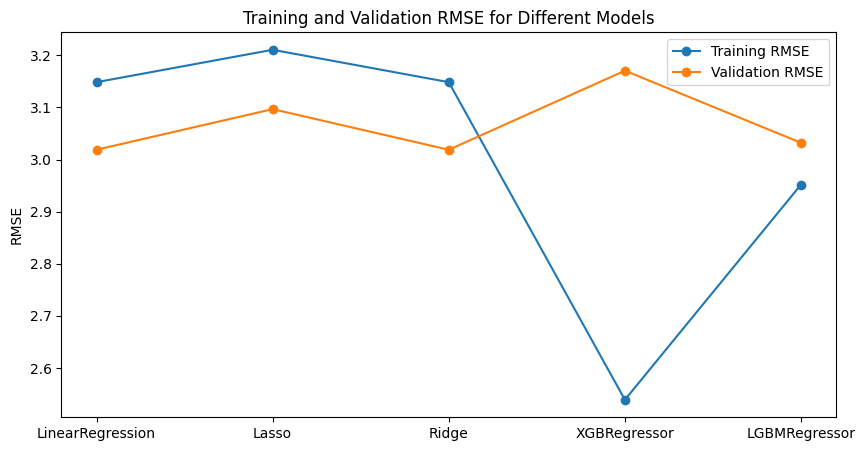

In [481]:
#(train / val) 시각화
plot_mse_for_models_line(models, X_train, y_train, X_val, y_val)

In [482]:
#모델 test평가
evaluate_models_on_test(models, X_test, y_test)

Model Test Performance Evaluation:

Model            	Test RMSE		Test R²
---------------------------------------------------------
LinearRegression 	3.2230		4.36%
Lasso            	3.2950		0.03%
Ridge            	3.2229		4.36%
XGBRegressor     	3.4149		-7.37%
LGBMRegressor    	3.2560		2.38%


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 3.01932	valid_0's l2: 9.11629


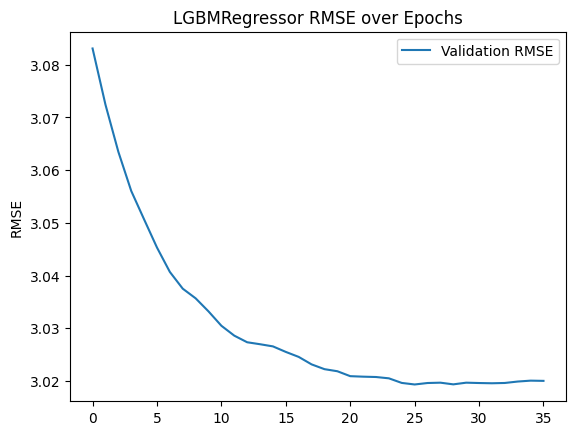

Best Iteration:  26


In [483]:
from lightgbm import LGBMRegressor, early_stopping
import matplotlib.pyplot as plt

# Initialize the model with verbosity settings
reg_lgbm = LGBMRegressor(verbose=-1)  # Set to -1 to suppress output, or a positive integer for verbosity
eval_set = [(X_val, y_val)]  # Evaluation set for early stopping

# Fit the model with early stopping
reg_lgbm.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set,
             callbacks=[early_stopping(stopping_rounds=10)])

# Accessing the RMSE values
results = reg_lgbm.evals_result_
epochs = len(results['valid_0']['rmse'])  # Adjust the key based on your evals_result structure
x_axis = range(0, epochs)

# Plotting
fig, ax = plt.subplots()
ax.plot(x_axis, results['valid_0']['rmse'], label='Validation RMSE')
ax.legend()
plt.ylabel('RMSE')
plt.title('LGBMRegressor RMSE over Epochs')
plt.show()

# Best iteration
best_iteration = reg_lgbm.best_iteration_
print("Best Iteration: ", best_iteration)


In [484]:
from sklearn.metrics import mean_squared_error, r2_score

# 테스트 데이터셋에 대한 예측 수행
pred_test = reg_lgbm.predict(X_test, num_iteration=best_iteration)

# 테스트 데이터셋에 대한 성능 평가
mse_test = mean_squared_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)

# 결과 출력
print("Test MSE: ", mse_test)
print("Test R² Score: {:.2f}%".format(r2_test * 100))


Test MSE:  10.478679804679611
Test R² Score: 3.52%


In [485]:
pred_test = reg_lgbm.predict(test_x, num_iteration=best_iteration)

In [494]:
Target_Encoder_lgb = pd.read_csv('./sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: './sample_submission.csv'

In [ ]:
Target_Encoder_lgb

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0
...,...,...
10958,ACCIDENT_50567,0
10959,ACCIDENT_50568,0
10960,ACCIDENT_50569,0
10961,ACCIDENT_50570,0


In [ ]:
Target_Encoder_lgb['ECLO'] = pred_test

# 결과 확인
Target_Encoder_lgb

,ID,ECLO
0,ACCIDENT_39609,4.274907
1,ACCIDENT_39610,3.908902
2,ACCIDENT_39611,5.314074
3,ACCIDENT_39612,4.908276
4,ACCIDENT_39613,4.944901
...,...,...
10958,ACCIDENT_50567,5.381492
10959,ACCIDENT_50568,4.775145
10960,ACCIDENT_50569,5.298887
10961,ACCIDENT_50570,4.956869


In [ ]:
# Target_Encoder_lgb.to_csv("./Target_Encoder_lgb_early_delete_columns.csv", index=False)

In [ ]:
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1 as l1_regularizer, l2 as l2_regularizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l1 as l1_regularizer, l2 as l2_regularizer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasRegressor

import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l1 as l1_regularizer, l2 as l2_regularizer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasRegressor

# GPU 메모리 관리 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 현재 프로그램에 필요한 만큼의 GPU 메모리만 할당
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 성장을 설정해야만 합니다
        print(e)

# RMSLE 손실 함수 정의
def rmsle(y_true, y_pred):
    y_true = tf.maximum(tf.cast(y_true, tf.float32), 0)
    y_pred = tf.maximum(tf.cast(y_pred, tf.float32), 0)
    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
    return tf.sqrt(tf.reduce_mean(squared_error))

# 모델 생성 함수 정의
def create_model(learning_rate, l1_reg, l2_reg):
    input_layer = tf.keras.Input(shape=(len(train_x.columns),))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1_regularizer(l1_reg))(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2_regularizer(l2_reg))(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=rmsle,
                  metrics=[rmsle])
    return model

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred) #차이 손실함수 반환

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)


In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]
'''
#EarlyStopping
val_loss: 데이터 손실을 관찰하겠다는 의미
patience: 검증데이터의 손실이 (30) epoch동안 개선되지 않으면 훈련 중단
verbose = 2:  조기 주단이 발생했을 때 화면에 로그를 표시
#mode = min: 관찰하고 있는 메트릭이 최소화 (손실 최소화)
restore_best_weights = true: 조기 중단 발생시 가장 좋은 가중치로 모델 복원

#ReduceLROnPlateau: 학습률을 동적으로 조정하는데 사용
monitor = val_loss: 검증 데이터이 손실 관찰
factor = 0.8: 손실이 개선되지 않을 때 학습률 80% 감소
patience: 3에포크 동안 손실 개선되지 않으면 학습률 조정
min_lr = 0.00001은 학습률의 하한선 설정

#TreminateOnNaN:
수치적 불안정성으로 인해 손실이 NAN이 되는 경우 훈련 즉시 중단.


'''

'\n#EarlyStopping\nval_loss: 데이터 손실을 관찰하겠다는 의미\npatience: 검증데이터의 손실이 (30) epoch동안 개선되지 않으면 훈련 중단\nverbose = 2:  조기 주단이 발생했을 때 화면에 로그를 표시\n#mode = min: 관찰하고 있는 메트릭이 최소화 (손실 최소화)\nrestore_best_weights = true: 조기 중단 발생시 가장 좋은 가중치로 모델 복원\n\n#ReduceLROnPlateau: 학습률을 동적으로 조정하는데 사용\nmonitor = val_loss: 검증 데이터이 손실 관찰\nfactor = 0.8: 손실이 개선되지 않을 때 학습률 80% 감소\npatience: 3에포크 동안 손실 개선되지 않으면 학습률 조정\nmin_lr = 0.00001은 학습률의 하한선 설정\n\n#TreminateOnNaN:\n수치적 불안정성으로 인해 손실이 NAN이 되는 경우 훈련 즉시 중단.\n\n\n'

In [ ]:
Best= {'batch_size': 128, 'l1_reg': 0.0001, 'l2_reg': 0.0001, 'learning_rate': 0.01}


In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1 as l1_regularizer, l2 as l2_regularizer

# 최적화된 하이퍼파라미터를 받아 모델을 생성하는 함수
def create_optimized_model(l1_reg, l2_reg, learning_rate):
    input_layer = tf.keras.Input(shape=(len(train_x.columns),))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l1_regularizer(l1_reg))(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2_regularizer(l2_reg))(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=loss_fn,
                  metrics=[metric_fn])
    return model

# 최적화된 하이퍼파라미터를 사용하여 모델 생성
best_params = Best
optimized_model = create_optimized_model(best_params['l1_reg'], best_params['l2_reg'], best_params['learning_rate'])

# 모델 학습
history = optimized_model.fit(train_x.astype('float32'), train_y.astype('float32'),
                              epochs=100, batch_size=best_params['batch_size'], verbose=1,
                              validation_split=0.1, callbacks=callbacks_list)


Epoch 1/100


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
262/279 [===========================>..] - ETA: 0s - loss: 0.4849 - metric_fn: 0.4769

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
279/279 [==============================] - 3s 4ms/step - loss: 0.4826 - metric_fn: 0.4748 - val_loss: 0.4516 - val_metric_fn: 0.4449 - lr: 0.0100
Epoch 2/100
279/279 [==============================] - 1s 2ms/step - loss: 0.4534 - metric_fn: 0.4478 - val_loss: 0.4358 - val_metric_fn: 0.4310 - lr: 0.0100
Epoch 3/100
279/279 [==============================] - 1s 2ms/step - loss: 0.4507 - metric_fn: 0.4470 - val_loss: 0.4304 - val_metric_fn: 0.4270 - lr: 0.0100
Epoch 4/100
279/279 [==============================] - 1s 2ms/step - loss: 0.4484 - metric_fn: 0.4454 - val_loss: 0.4294 - val_metric_fn: 0.4270 - lr: 0.0100
Epoch 5/100
279/279 [================

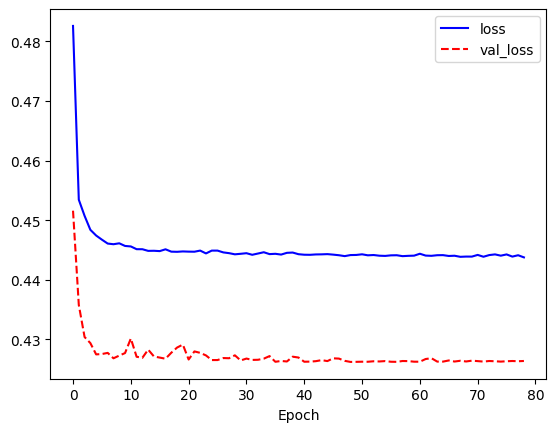

In [ ]:
# train loss, val loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()